# Setting up the environment

In [52]:
pip install contractions

In [54]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# For preprocessing
import unicodedata   ## Removing Accented Characters
import contractions #from contractions.py ##Expanding Contractions
import re ## Removing Special Character
import spacy  ## Lemmatization
nlp = spacy.load('en_core_web_sm')
import string ## Removing Punctuation
import nltk ##Stemming
from nltk.tokenize import ToktokTokenizer ## Removing Stopwords
tokenizer = ToktokTokenizer() ## Removing Stopwords
stopword_list = nltk.corpus.stopwords.words('english') ## Removing Stopwords
from sklearn.feature_extraction.text import TfidfVectorizer ##TfIdf

In [55]:
#Reading Data
train_data = pd.read_csv("/content/drive/MyDrive/Data_Mining_Assignment/data/train-balanced.csv", sep='\t')
keys = pd.read_csv("/content/drive/MyDrive/Data_Mining_Assignment/data/key.csv", sep='\t')


#Adding column names to train and test dataframe
train_data.columns = keys.columns
train_data.dropna(subset=['comment'], inplace=True) ## Dropping rows with no comments
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010772 entries, 0 to 1010824
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010772 non-null  int64 
 1   comment         1010772 non-null  object
 2   author          1010772 non-null  object
 3   subreddit       1010772 non-null  object
 4   score           1010772 non-null  int64 
 5   ups             1010772 non-null  int64 
 6   downs           1010772 non-null  int64 
 7   date            1010772 non-null  object
 8   created_utc     1010772 non-null  int64 
 9   parent_comment  1010772 non-null  object
dtypes: int64(5), object(5)
memory usage: 84.8+ MB


In [56]:
train_data

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,1477959850,The blazers and Mavericks (The wests 5 and 6 s...
1,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,1474580737,They're favored to win.
2,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,1476824627,deadass don't kill my buzz
3,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,1483117213,Yep can confirm I saw the tool they use for th...
4,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,1472812508,do you find ariana grande sexy ?
...,...,...,...,...,...,...,...,...,...,...
1010820,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,1240620472,"No one is calling this an engineered pathogen,..."
1010821,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,1242340060,In a move typical of their recent do-nothing a...
1010822,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,1231633377,Screw the Disabled--I've got to get to Church ...
1010823,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,1232745169,I've always been unsettled by that. I hear a l...


# Data Preparation

In [57]:
## Defining Data cleaning Functions

# Removing Accented Characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

# Removing Special Characters except "", '', and !
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9!\"\',?/:;\s]' 
    return re.sub(pat, '', text)

# Removing StopWords
def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # check in lowercase 
    t = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(t)    
    return text

# Removing extra whitespaces and tabs
def remove_extra_whitespace_tabs(text):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

In [58]:
## Calling the Functions
train_data['cleancomment']=train_data['comment'].map(lambda s:remove_accented_chars(s))
train_data['cleancomment']=train_data['cleancomment'].map(lambda s:remove_special_characters(s))
train_data['cleancomment']=train_data['cleancomment'].map(lambda s:remove_stopwords(s))
train_data['cleancomment']=train_data['cleancomment'].map(lambda s:remove_extra_whitespace_tabs(s))

## Combining "Comment", "Subreddit" and "Author" to get better results
train_data['all'] = train_data.agg('{0[cleancomment]} {0[subreddit]} {0[author]}'.format, axis=1)

In [59]:
train_data = train_data.drop(['comment', 'author', 'subreddit', 'score', 'downs', 'ups', 'date', 'created_utc', 'parent_comment', 'cleancomment'], axis=1)
train_data.head()

,label,all
0,0,know west teams play west teams east teams rig...
1,0,"underdogs earlier today , since Gronk ' announ..."
2,0,"meme ' funny none "" new york nigga "" ones Blac..."
3,0,could use one tools MaddenUltimateTeam cush2push
4,0,"' pay attention , long ' legal ' kick bed took..."


In [60]:
train_data.rename(columns = {'label':'target'}, inplace = True)
train_data.rename(columns = {'all':'text'}, inplace = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010772 entries, 0 to 1010824
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1010772 non-null  int64 
 1   text    1010772 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [61]:
sar_train_data = train_data[train_data['target'] == 1]
neu_train_data = train_data[train_data['target'] == 0]
sar_train_data = sar_train_data[:25000]
neu_train_data = neu_train_data[:25000]
del train_data
frames = [sar_train_data, neu_train_data]
train_data = pd.concat(frames, sort=False)

In [62]:
train_data

,target,text
32,1,' reviews ! ProductTesting RoguishPoppet
43,1,wow totally unreasonable assume agency covered...
44,1,Ho ho ho Melania said way could happened ' kno...
65,1,' wait potus starts twitter war Morning Joe po...
68,1,gotta love teachers give exams day halloween C...
...,...,...
42332,0,AYY OH AYY kpop plasmicPyrotechnic
42333,0,15 kegs 2 epics : 400 scraps thoooo gwent Klydex4
42336,0,' even want think inside looks like pcmasterra...
42337,0,Quite lot working Overwatch ElysiumProject Cry...


In [63]:
x = train_data.text
y = train_data.target

In [64]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [65]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 49000 entries with 49.98% negative, 50.02% positive
Validation set has total 500 entries with 49.40% negative, 50.60% positive
Test set has total 500 entries with 53.00% negative, 47.00% positive


# Training ANN model with TFIDF

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec1 = TfidfVectorizer(max_features=100000)
tvec1.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=100000, min_df=1, ngram_range=(1, 1), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [18]:
 len(tvec1.get_feature_names())

74469

In [67]:
x_train_tfidf = tvec1.transform(x_train)

In [20]:
x_train_tfidf

<49000x74469 sparse matrix of type '<class 'numpy.float64'>'
	with 356255 stored elements in Compressed Sparse Row format>

In [68]:
x_validation_tfidf = tvec1.transform(x_validation).toarray()

In [ ]:
x_validation_tfidf.shape

(500, 73114)

In [92]:
x_test_tfidf = tvec1.transform(x_test).toarray()

In [22]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(x_train_tfidf, y_train)

CPU times: user 3.22 s, sys: 4.33 s, total: 7.55 s
Wall time: 3.98 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [105]:
clf.score(x_validation_tfidf, y_validation)

0.678

In [24]:
clf.score(x_train_tfidf, y_train)

0.8226326530612245

In [106]:
clf.score(x_test_tfidf, y_test)

0.67

In [69]:
seed = 7
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [70]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield np.array(X_batch),np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

In [27]:
%%time
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=74469))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1531/1531 [==============================] - 71s 46ms/step - loss: 0.6609 - accuracy: 0.6027 - val_loss: 0.6056 - val_accuracy: 0.6720
Epoch 2/5
1531/1531 [==============================] - 70s 45ms/step - loss: 0.4672 - accuracy: 0.7824 - val_loss: 0.7274 - val_accuracy: 0.6320
Epoch 3/5
1531/1531 [==============================] - 69s 45ms/step - loss: 0.2563 - accuracy: 0.8953 - val_loss: 0.9769 - val_accuracy: 0.5880
Epoch 4/5
1531/1531 [==============================] - 69s 45ms/step - loss: 0.1188 - accuracy: 0.9574 - val_loss: 1.2451 - val_accuracy: 0.5780
Epoch 5/5
1531/1531 [==============================] - 67s 44ms/step - loss: 0.0559 - accuracy: 0.9821 - val_loss: 1.5215 - val_accuracy: 0.5780
CPU times: user 10min 2s, sys: 11.1 s, total: 10min 13s
Wall time: 5min 46s


# Normalizing the inputs to improve the performance of the ANN

In [28]:
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit(x_train_tfidf)
x_train_tfidf_norm = norm.transform(x_train_tfidf)
x_validation_tfidf_norm = norm.transform(x_validation_tfidf)

In [29]:
%%time
model_n = Sequential()
model_n.add(Dense(64, activation='relu', input_dim=74469))
model_n.add(Dense(1, activation='sigmoid'))
model_n.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_n.fit_generator(generator=batch_generator(x_train_tfidf_norm, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf_norm, y_validation),
                    steps_per_epoch=x_train_tfidf_norm.shape[0]/32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1531/1531 [==============================] - 71s 46ms/step - loss: 0.6600 - accuracy: 0.6033 - val_loss: 0.6062 - val_accuracy: 0.6700
Epoch 2/5
1531/1531 [==============================] - 70s 46ms/step - loss: 0.4666 - accuracy: 0.7848 - val_loss: 0.7238 - val_accuracy: 0.6260
Epoch 3/5
1531/1531 [==============================] - 71s 46ms/step - loss: 0.2527 - accuracy: 0.8991 - val_loss: 0.9664 - val_accuracy: 0.5760
Epoch 4/5
1531/1531 [==============================] - 70s 46ms/step - loss: 0.1156 - accuracy: 0.9595 - val_loss: 1.2336 - val_accuracy: 0.5640
Epoch 5/5
1531/1531 [==============================] - 70s 46ms/step - loss: 0.0536 - accuracy: 0.9833 - val_loss: 1.5120 - val_accuracy: 0.5780
CPU times: user 10min 14s, sys: 11.5 s, total: 10min 25s
Wall time: 5min 52s


# Using Dropout

In [30]:
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim=74469))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1531/1531 [==============================] - 67s 44ms/step - loss: 0.6617 - accuracy: 0.6050 - val_loss: 0.6036 - val_accuracy: 0.6780
Epoch 2/5
1531/1531 [==============================] - 66s 43ms/step - loss: 0.4848 - accuracy: 0.7721 - val_loss: 0.6924 - val_accuracy: 0.6440
Epoch 3/5
 673/1531 [============>.................] - ETA: 37s - loss: 0.3234 - accuracy: 0.8641

KeyboardInterrupt: ignored

There is another method I can try to prevent overfitting. By presenting the data in the same order for every epoch, there's a possibility that the model learns the parameters which also includes the noise of the training data, which eventually leads to overfitting. This can be improved by shuffling the order of the data we feed the model. Below I added shuffling to the batch generator function and tried with the same model structure and compared the result.

# Using CustomeCallback Function to understand the best accuracy

In [88]:
import keras
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_test_batch_end(self, batch, logs=None):
       print("For batch {}, accuracy is {:7.2f}.".format(batch, logs["accuracy"]))

    def on_train_batch_end(self, batch, logs=None):
      print("For batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    #def on_predict_end(self, logs=None):
    #    keys = list(logs.keys())
    #    print("Stop predicting; got log keys: {}".format(keys))

    # def on_predict_batch_end(self, batch, logs=None):
    #    print("...Predicting: end of batch {}; got log keys (loss): {}".format(batch, logs["loss"]))

    # def on_epoch_end(self, epoch, logs=None):
    #     print(
    #         "3. The average loss for epoch {} is {:7.2f} "
    #         "and accuracyr is {:7.2f}.".format(
    #             epoch, logs["loss"], logs["accuracy"]
    #         )
    #     )

In [89]:
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim=74469))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=1, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32,
                     callbacks=[LossAndErrorPrintingCallback()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


   1/1531 [..............................] - ETA: 13:15 - loss: 0.6930 - accuracy: 0.4688For batch 0, loss is    0.69.
For batch 1, loss is    0.69.
   3/1531 [..............................] - ETA: 1:07 - loss: 0.6932 - accuracy: 0.4410 For batch 2, loss is    0.69.
For batch 3, loss is    0.69.
   5/1531 [..............................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.4546For batch 4, loss is    0.69.
For batch 5, loss is    0.69.
   7/1531 [..............................] - ETA: 1:06 - loss: 0.6931 - accuracy: 0.4654For batch 6, loss is    0.69.
For batch 7, loss is    0.69.
   9/1531 [..............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.4711For batch 8, loss is    0.69.
For batch 9, loss is    0.69.
  14/1531 [..............................] - ETA: 1:10 - loss: 0.6931 - accuracy: 0.4793For batch 13, loss is    0.69.
For batch 14, loss is    0.69.
  16/1531 [..............................] - ETA: 1:10 - loss: 0.6930 - accuracy: 0.4820For batch 15, loss i

# Stopping the model at highest accuracy

In [90]:
import keras
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [91]:
model1_best = Sequential()
model1_best.add(Dense(64, activation='relu', input_dim=74469))
model1_best.add(Dropout(0.2))
model1_best.add(Dense(1, activation='sigmoid'))
model1_best.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_best.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=1, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32,
                     callbacks=[EarlyStoppingAtMinLoss()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1531/1531 [==============================] - 71s 46ms/step - loss: 0.6619 - accuracy: 0.6010 - val_loss: 0.6034 - val_accuracy: 0.6800


In [93]:
import keras
class CustomPredictCallback(keras.callbacks.Callback):
  def on_predict_batch_end(self, batch, logs=None):
        print("For batch {}, accuracy is {:7.2f}.".format(batch, logs["accuracy"]))

In [96]:
result = model1_best.evaluate(x_test_tfidf, y_test, verbose = 0)
print(result[1])

0.6539999842643738


In [97]:
val_result = model1_best.evaluate(x_validation_tfidf, y_validation, verbose = 0)
print(val_result[1])

0.6800000071525574


# Saving the above best model

In [98]:
# save model and architecture to single file
model1_best.save("/content/drive/MyDrive/Data_Mining_Assignment/custom_model.h5")
print("Saved model to disk")

Saved model to disk


In [103]:
from keras.models import load_model
model1_best = load_model('/content/drive/MyDrive/Data_Mining_Assignment/custom_model.h5')

In [104]:
result = model1_best.evaluate(x_test_tfidf, y_test, verbose = 0)
print(result[1])

0.6539999842643738


# Trying batches to train the NN

In [35]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        #X_batch = X_data[index_batch,:]
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield np.array(X_batch),np.array(y_batch)
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

In [36]:
%%time
model_s = Sequential()
model_s.add(Dense(64, activation='relu', input_dim=74469))
model_s.add(Dense(1, activation='sigmoid'))
model_s.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
1531/1531 [==============================] - 70s 45ms/step - loss: 0.6610 - accuracy: 0.5976 - val_loss: 0.6087 - val_accuracy: 0.6580
Epoch 2/2
1531/1531 [==============================] - 68s 45ms/step - loss: 0.4245 - accuracy: 0.8229 - val_loss: 0.7342 - val_accuracy: 0.6520
CPU times: user 4min 2s, sys: 4.34 s, total: 4min 6s
Wall time: 2min 18s


# Trying to Tweak the Leaning Rate

In [ ]:
%%time
import keras
custom_adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_2 = Sequential()
model_testing_2.add(Dense(64, activation='relu', input_dim=74469))
model_testing_2.add(Dense(1, activation='sigmoid'))
model_testing_2.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1531/1531 [==============================] - 73s 48ms/step - loss: 0.6538 - accuracy: 0.6052 - val_loss: 0.6115 - val_accuracy: 0.6700
Epoch 2/2
1531/1531 [==============================] - 74s 48ms/step - loss: 0.3648 - accuracy: 0.8391 - val_loss: 0.8442 - val_accuracy: 0.6460
CPU times: user 4min 16s, sys: 4.01 s, total: 4min 20s
Wall time: 2min 27s


In [ ]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_3 = Sequential()
model_testing_3.add(Dense(64, activation='relu', input_dim=74469))
model_testing_3.add(Dense(1, activation='sigmoid'))
model_testing_3.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_3.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1531/1531 [==============================] - 75s 49ms/step - loss: 0.6534 - accuracy: 0.6044 - val_loss: 0.6287 - val_accuracy: 0.6540
Epoch 2/2
1531/1531 [==============================] - 75s 49ms/step - loss: 0.3530 - accuracy: 0.8403 - val_loss: 0.9010 - val_accuracy: 0.6280
CPU times: user 4min 21s, sys: 4.58 s, total: 4min 26s
Wall time: 2min 30s


In [ ]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_4 = Sequential()
model_testing_4.add(Dense(64, activation='relu', input_dim=74469))
model_testing_4.add(Dense(1, activation='sigmoid'))
model_testing_4.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_4.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1531/1531 [==============================] - 73s 48ms/step - loss: 0.6742 - accuracy: 0.5755 - val_loss: 0.6771 - val_accuracy: 0.6420
Epoch 2/2
1531/1531 [==============================] - 75s 49ms/step - loss: 0.4920 - accuracy: 0.7391 - val_loss: 0.7487 - val_accuracy: 0.6460
CPU times: user 4min 19s, sys: 4.2 s, total: 4min 23s
Wall time: 2min 28s


In [ ]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_5 = Sequential()
model_testing_5.add(Dense(64, activation='relu', input_dim=74469))
model_testing_5.add(Dense(1, activation='sigmoid'))
model_testing_5.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_5.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1531/1531 [==============================] - 76s 49ms/step - loss: 0.6698 - accuracy: 0.5916 - val_loss: 0.5981 - val_accuracy: 0.6760
Epoch 2/5
1531/1531 [==============================] - 75s 49ms/step - loss: 0.4746 - accuracy: 0.8001 - val_loss: 0.6654 - val_accuracy: 0.6700
Epoch 3/5
1531/1531 [==============================] - 75s 49ms/step - loss: 0.3032 - accuracy: 0.8940 - val_loss: 0.8039 - val_accuracy: 0.6380
Epoch 4/5
1531/1531 [==============================] - 75s 49ms/step - loss: 0.1804 - accuracy: 0.9437 - val_loss: 1.0007 - val_accuracy: 0.6120
Epoch 5/5
1531/1531 [==============================] - 74s 49ms/step - loss: 0.1086 - accuracy: 0.9676 - val_loss: 1.1794 - val_accuracy: 0.6080
CPU times: user 10min 54s, sys: 11.5 s, total: 11min 5s
Wall time: 6min 15s


In [ ]:
%%time
model_s_2 = Sequential()
model_s_2.add(Dense(128, activation='relu', input_dim=74469))
model_s_2.add(Dense(1, activation='sigmoid'))
model_s_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1531/1531 [==============================] - 115s 75ms/step - loss: 0.6589 - accuracy: 0.5952 - val_loss: 0.6080 - val_accuracy: 0.6740
Epoch 2/2
1531/1531 [==============================] - 114s 75ms/step - loss: 0.4089 - accuracy: 0.8271 - val_loss: 0.7634 - val_accuracy: 0.6440
CPU times: user 6min 42s, sys: 5.24 s, total: 6min 48s
Wall time: 3min 49s


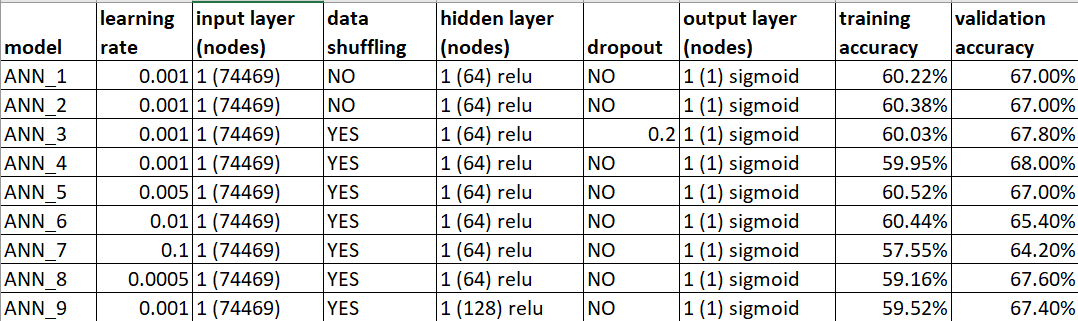

# Implementing PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
clf = TruncatedSVD(300)
#x_train_tfidf = clf.fit_transform(x_train_tfidf)

In [ ]:
x_train_tfidf.shape

(49000, 300)

In [ ]:
x_train_tfidf

array([[ 2.20227856e-02, -5.15677812e-05, -2.60054259e-02, ...,
         1.73327051e-02, -2.00690388e-03, -6.52476915e-03],
       [ 2.11651967e-04, -7.58171475e-05, -1.54072167e-04, ...,
        -5.59536754e-04, -8.52818149e-04,  3.39897394e-04],
       [ 2.75658280e-02, -7.70696641e-03, -6.20610372e-02, ...,
         3.80152931e-04, -3.54484263e-04, -2.23806390e-04],
       ...,
       [ 7.41418266e-02, -5.79971508e-03, -6.02815992e-02, ...,
        -4.82838764e-03,  1.08221591e-02, -6.79233548e-03],
       [ 4.07157245e-02,  2.14566152e-03, -2.45256757e-02, ...,
        -3.62892844e-02,  8.41696669e-02, -2.88153204e-02],
       [ 9.09875237e-03,  7.63013494e-05, -8.38156859e-03, ...,
         3.94898494e-03,  2.13498322e-02, -2.93964695e-02]])

In [ ]:
x_validation_tfidf = clf.fit_transform(x_validation_tfidf)

In [ ]:
x_validation_tfidf.shape

(1000, 300)

In [ ]:
%%time
import keras
model_s = Sequential()
custom_adam = keras.optimizers.Adam(lr=0.001)
model_s.add(Dense(64, activation='relu', input_dim=300))
model_s.add(Dropout(0.5))
model_s.add(Dense(1, activation='sigmoid'))
model_s.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=30, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1531/1531 [==============================] - 4s 2ms/step - loss: 0.6784 - accuracy: 0.5704 - val_loss: 0.7893 - val_accuracy: 0.5060
Epoch 2/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.6418 - accuracy: 0.6245 - val_loss: 0.8336 - val_accuracy: 0.5300
Epoch 3/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.6358 - accuracy: 0.6327 - val_loss: 0.8428 - val_accuracy: 0.5300
Epoch 4/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.6361 - accuracy: 0.6307 - val_loss: 0.8709 - val_accuracy: 0.5280
Epoch 5/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.6328 - accuracy: 0.6348 - val_loss: 0.8740 - val_accuracy: 0.5200
Epoch 6/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.6333 - accuracy: 0.6354 - val_loss: 0.9016 - val_accuracy: 0.5160
Epoch 7/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.6292 - accuracy: 0.6382 - val_loss: 0.9024 - val_accuracy:

In [ ]:
%%time
import keras
model_s = Sequential()
custom_adam = keras.optimizers.Adam(lr=0.001)
model_s.add(Dense(150, activation='relu', input_dim=300))
model_s.add(Dropout(0.5))
model_s.add(Dense(64, activation='relu'))
model_s.add(Dropout(0.3))
model_s.add(Dense(1, activation='sigmoid'))
model_s.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=100, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1531/1531 [==============================] - 5s 3ms/step - loss: 0.6717 - accuracy: 0.5732 - val_loss: 0.8207 - val_accuracy: 0.5300
Epoch 2/100
1531/1531 [==============================] - 4s 3ms/step - loss: 0.6391 - accuracy: 0.6275 - val_loss: 0.8365 - val_accuracy: 0.5300
Epoch 3/100
1531/1531 [==============================] - 4s 3ms/step - loss: 0.6337 - accuracy: 0.6359 - val_loss: 0.8614 - val_accuracy: 0.5260
Epoch 4/100
1531/1531 [==============================] - 4s 2ms/step - loss: 0.6287 - accuracy: 0.6412 - val_loss: 0.8560 - val_accuracy: 0.5220
Epoch 5/100
1531/1531 [==============================] - 4s 3ms/step - loss: 0.6227 - accuracy: 0.6477 - val_loss: 0.9172 - val_accuracy: 0.5120
Epoch 6/100
1531/1531 [==============================] - 4s 3ms/step - loss: 0.6151 - accuracy: 0.6538 - val_loss: 0.9921 - val_accuracy: 0.4980
Epoch 7/100
1531/1531 [==============================] - 4s 2ms/step - loss: 0.6095 - accuracy: 0.6635 - val_loss: 0.9465 - val_ac

# Trying new dataset to check for results

In [ ]:
train_data = train_data[train_data['text'].str.len() <=200]
train_data

,target,text
0,0,know west teams play west teams east teams rig...
1,0,"underdogs earlier today , since Gronk ' announ..."
2,0,"meme ' funny none "" new york nigga "" ones Blac..."
3,0,could use one tools MaddenUltimateTeam cush2push
4,0,"' pay attention , long ' legal ' kick bed took..."
...,...,...
1010820,1,' sure Iran N Korea technology create pig/bird...
1010821,1,"whatever , ' vote green ! climate BCHarvey"
1010822,1,Perhaps atheist conspiracy make Christians loo...
1010823,1,Slavs got country called Kosovo worldnews catsi


In [ ]:
sar_train_data = train_data[train_data['target'] == 1]
neu_train_data = train_data[train_data['target'] == 0]
sar_train_data = sar_train_data.tail(50000)
neu_train_data = neu_train_data.tail(50000)

In [ ]:
frames = [sar_train_data, neu_train_data]
new_train_data = pd.concat(frames, sort=False)

In [ ]:
new_train_data.head()

,target,text
920196,1,"nop lun wrost pone hole show , 1 mylittlepony ..."
920197,1,steering wheel wrong side pics celluj34
920198,1,love letting game run overnight get rent villa...
920199,1,"Sure , upvotes/downvotes agree/disagree button..."
920200,1,cardinals set record biggest shut loss ? nfl c...


In [ ]:
x = new_train_data.text
y = new_train_data.target

In [ ]:
from sklearn.model_selection import train_test_split
SEED = 567
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [ ]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 98000 entries with 50.04% negative, 49.96% positive
Validation set has total 1000 entries with 48.40% negative, 51.60% positive
Test set has total 1000 entries with 48.00% negative, 52.00% positive


In [ ]:
tvec1.fit(x_train)
x_train_tfidf = tvec1.transform(x_train)
x_validation_tfidf = tvec1.transform(x_validation).toarray()
x_train_tfidf = clf.fit_transform(x_train_tfidf)
x_validation_tfidf = clf.fit_transform(x_validation_tfidf)

In [ ]:
%%time
import keras
model_s = Sequential()
custom_adam = keras.optimizers.Adam(lr=0.0001)
model_s.add(Dense(150, activation='relu'))
model_s.add(Dropout(0.5))
model_s.add(Dense(64, activation='relu'))
model_s.add(Dropout(0.5))
model_s.add(Dense(1, activation='sigmoid'))
model_s.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=100, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
3062/3062 [==============================] - 7s 2ms/step - loss: 0.6894 - accuracy: 0.5327 - val_loss: 0.7064 - val_accuracy: 0.5350
Epoch 2/100
3062/3062 [==============================] - 6s 2ms/step - loss: 0.6456 - accuracy: 0.6317 - val_loss: 0.7794 - val_accuracy: 0.5250
Epoch 3/100
3062/3062 [==============================] - 6s 2ms/step - loss: 0.6288 - accuracy: 0.6471 - val_loss: 0.7967 - val_accuracy: 0.5170
Epoch 4/100
3062/3062 [==============================] - 6s 2ms/step - loss: 0.6254 - accuracy: 0.6492 - val_loss: 0.8111 - val_accuracy: 0.5230
Epoch 5/100
3062/3062 [==============================] - 6s 2ms/step - loss: 0.6217 - accuracy: 0.6545 - val_loss: 0.8133 - val_accuracy: 0.5290
Epoch 6/100
3062/3062 [==============================] - 6s 2ms/step - loss: 0.6205 - accuracy: 0.6576 - val_loss: 0.8227 - val_accuracy: 0.5260
Epoch 7/100
3062/3062 [==============================] - 6s 2ms/step - loss: 0.6202 - accuracy: 0.6569 - val_loss: 0.8280 - val_ac

In [ ]:
x_test_tfidf = tvec1.transform(x_test).toarray()
x_test_tfidf = clf.fit_transform(x_test_tfidf)
x_test_tfidf.shape


(1000, 300)

In [ ]:
test_pred = model_s.predict(x_test_tfidf)

In [ ]:
score = model_s.evaluate(x_test_tfidf, y_test) 

32/32 [==============================] - 0s 1ms/step - loss: 1.1910 - accuracy: 0.5160
